In [1]:
from lightcurve import occultation_bic
import numpy as np
import mpyfit
from pandas import DataFrame
from scipy.stats import chisquare

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt 
from matplotlib.gridspec import GridSpec

def init_plotting():
    plt.rcParams['figure.figsize'] = (14.0,8.0)
    plt.rcParams['font.size'] = 20
    #plt.rcParams['font.family'] = 'Times New Roman'
    plt.rcParams['axes.labelsize'] = plt.rcParams['font.size']
    plt.rcParams['axes.titlesize'] = 0.75*plt.rcParams['font.size']
    plt.rcParams['legend.fontsize'] = 0.65*plt.rcParams['font.size']
    plt.rcParams['xtick.labelsize'] = plt.rcParams['font.size']
    plt.rcParams['ytick.labelsize'] = plt.rcParams['font.size']
    plt.rcParams['xtick.major.size'] = 3
    plt.rcParams['xtick.minor.size'] = 3
    plt.rcParams['xtick.major.width'] = 1
    plt.rcParams['xtick.minor.width'] = 1
    plt.rcParams['ytick.major.size'] = 3
    plt.rcParams['ytick.minor.size'] = 3
    plt.rcParams['ytick.major.width'] = 1
    plt.rcParams['ytick.minor.width'] = 1
    plt.rcParams['legend.frameon'] = True
    plt.rcParams['legend.loc'] = 'best'
    plt.rcParams['axes.linewidth'] = 1

init_plotting()

In [3]:
ls

Allflux/                                 raw_data.png  sysparams.txt
Example of the lightcurve package.ipynb  Results/


In [4]:
a_Rs, Rp_Rs, radstar, i, a, e, omega, epoch, period, limbB1, limbB2 = occultation_bic.sysparams('./sysparams.txt')

In [5]:
print 'a_Rs =',a_Rs
print 'Rp_Rs =',Rp_Rs
print 'radstar =',radstar
print 'i =',i
print 'a =',a
print 'e =',e
print 'omega =',omega
print 'epoch =',epoch
print 'period =',period
print 'limbB1 =',limbB1
print 'limbB2 =',limbB2

a_Rs = 7.986
Rp_Rs = 0.10304
radstar = 0.99
i = 88.01
a = 0.0368
e = 0.0
omega = 0.0
epoch = 2454508.73829
period = 2.61586178
limbB1 = 0.81461289
limbB2 = 0.02619382


In [6]:
#Change for the rigth units
inc = np.radians(i) #inclination in radians
semimajoraxis = a
semimajoraxis = semimajoraxis *1.49598e13 # convert semi-major axis (a) from AU to m
radstar = radstar * 6.955e10 # convert stellar radius from Solar Radii to m
radplanet = radstar * Rp_Rs #calculate planetary radius in m based on Rp/Rs and stellar radius

In [7]:
pwd

u'/home/walter/MEGA/work/codes/MYpackages/lightcurve/lightcurve/example'

In [8]:
#set the correct paths, change this for run correctly 
#where is the allflux* and the error_allflux* files
path = '/home/walter/MEGA/work/codes/MYpackages/lightcurve/lightcurve/example/Allflux/' 
hjd_path = '/home/walter/MEGA/work/codes/MYpackages/lightcurve/lightcurve/example/Results/hjd'
airmass_path='/home/walter/MEGA/work/codes/MYpackages/lightcurve/lightcurve/example/Results/XYpos+Airmass.txt'

In [9]:
hjd, rawflux, eflux, am = occultation_bic.read_files(path,hjd_path,airmass_path)

Total of files =  70
Percent: [##########] 100% Done...
The smallest scatter is: 27808.2230678
Which is file: allflux13.9
Working @allflux13.9 that is the min scatter
... Read allflux13.9 ...
... done.
... Read error_allfluxerr13.9 ...
... done


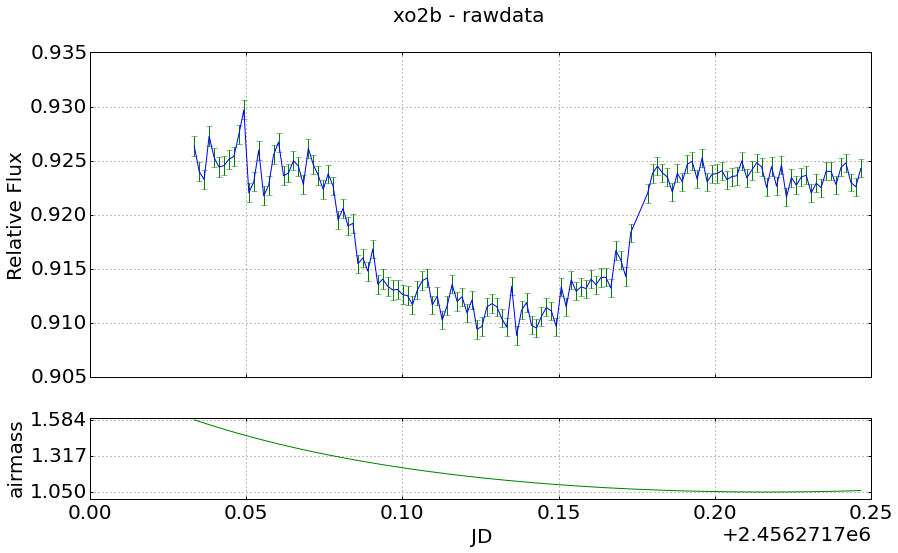

In [10]:
f = plt.figure()
plt.suptitle("xo2b - rawdata")
gs1 = GridSpec(2, 2, width_ratios=[1,2],height_ratios=[4,1])
gs1.update(wspace=0.5)
ax1 = plt.subplot(gs1[:-1, :])
ax2 = plt.subplot(gs1[-1, :])
ax1.grid()
ax1.errorbar(hjd,rawflux,yerr=eflux,ecolor='g')
ax1.set_xticklabels([])
ax1.set_ylabel('Relative Flux')
ax2.grid()
ax2.plot(hjd,am,color='green')
plt.yticks(np.array([am.min(), (am.min()+am.max())/2., am.max()]))
ax2.set_xlabel('JD')
ax2.set_ylabel('airmass')
plt.savefig('../raw_data.png')

In [16]:
def simple_model(JD, period, inc, a_Rs, limbB1, limbB2,startpar0, startpar1):
    phase = (JD - startpar1)/period
    distance_vector = delta(phase,inc) * a_Rs
    #model = occultation_fn(distance_vector,startpar0,limbB1,limbB2,show=False)
    model = occultquad(distance_vector, limbB1, limbB2, startpar0, len(JD))

    return model

def model_am_exp(hjd, period, inc, a_Rs, limbB1, limbB2,startpar0,startpar1,startpar2,startpar3):
    model = simple_model(hjd, period, inc, a_Rs, limbB1, limbB2,startpar0, startpar1)
    model_am = model * startpar2 * np.exp(-1. * startpar3 * am) #multiply light curve by factor x exponential
    return model_am

def residuals_am_exp(params,args): #residuals function for mpfit
    RpRs = params[0]
    Tc = params[1]
    mu1 = params[2]
    mu2 = params[3]
    hjd, data, eps_data, period, inc, a_Rs, limbB1, limbB2 = args
    model = model_am_exp(hjd, period, inc, a_Rs, limbB1, limbB2, RpRs,Tc,mu1,mu2)
    return (data-model)/eps_data

def model_am_linear(hjd, period, inc, a_Rs, limbB1, limbB2,startpar0,startpar1,startpar2,startpar3):
    model = simple_model(hjd, period, inc, a_Rs, limbB1, limbB2,startpar0, startpar1)
    model_am = model * (startpar2 * am + startpar3) #multiply light curve by factor x exponential
    return model_am

def residuals_linear(params,args): #residuals function for mpfit
    RpRs = params[0]
    Tc = params[1]
    mu1 = params[2]
    mu2 = params[3]
    hjd, data, eps_data, period, inc, a_Rs, limbB1, limbB2 = args
    model = model_am_linear(hjd, period, inc, a_Rs, limbB1, limbB2,RpRs,Tc,mu1,mu2)
    return (data-model)/eps_data

def model_am_2deg(hjd, period, inc, a_Rs, limbB1, limbB2,startpar0,startpar1,startpar2,startpar3,startpar4):
    model = simple_model(hjd, period, inc, a_Rs, limbB1, limbB2,startpar0, startpar1)
    model_am = model * (startpar2 + startpar3*am + startpar4*am) #multiply light curve by factor x exponential
    return model_am

def residuals_2deg_mpfit(params,args): #residuals function for mpfit
    RpRs = params[0]
    Tc = params[1]
    mu1 = params[2]
    mu2 = params[3]
    mu3 = params[4]
    hjd, data, eps_data, period, inc, a_Rs, limbB1, limbB2 = args
    model = model_am_2deg(hjd, period, inc, a_Rs, limbB1, limbB2,RpRs,Tc,mu1,mu2,mu3)
    return (data-model)/eps_data

def BIC(nfree,bestnorm, nflux):
    """
    Obtain the BIC value for the model.
    ___
    INPUT:
    nfre : number of free parameters
    bestnorm:
    nflux: number of points in the data


    OUTPUT:
    BIC: BIC number
    """
    if isinstance(nfree,(float,int)) == True:
        bic = nfree * np.log(nflux) + bestnorm
    else:
        bic = np.zeros(len(nfree))
        for i in range(len(nfree)):
            bic[i] = nfree[i] * np.log(nflux) + bestnorm[i]
    return bic

In [17]:
def model_airmassfit(hjd, am, rawflux, eflux, limbB1, limbB2, inc, period, a_Rs,Rp_Rs, show=False):
    """
    Return the bestfit model for the lightcurve using 4 models of airmass correction:
    1. model with no airmass correction
    2. model with exponential airmass correction
    3. model with linear airmass correction
    4, model with 2deg polynomial airmass correction
    ___
    INPUT:

    hjd:
    am:
    rawflux:
    eflux:
    limbB1:
    limbB2:
    inc:
    period:
    a_Rs:
    startpar:

    OUTPUT:
    result: dataframe structure with besfit values for each model, the errors and BIC values.
    phase: from the bestfit model
    lc: lightcurve from the bestfit model
    """
    # Model 1: no airmass correction
    startpar = [Rp_Rs, np.mean(hjd), 1., 0.]
    PARINFO = [{'value':Rp_Rs,'limits':(0,1.)}, {'value':np.mean(hjd)}, {'value':1.}, {'value':0.,'fixed':True}]
    pfit1, results1 = mpyfit.fit(residuals_am_exp, startpar, args = (hjd, rawflux, eflux, period, inc, a_Rs, limbB1, limbB2), parinfo=PARINFO)
    model1 = model_am_exp(hjd, period, inc, a_Rs, limbB1, limbB2,pfit1[0],pfit1[1],pfit1[2],pfit1[3])
    phase1 = (hjd - pfit1[1])/period
    if show == True:
        print '...'
        print 'Model 1: no airmass correction'
        print 'bestfit values = ',pfit1
        print 'error = ', results1['parerrors']
        print 'bestnorm1 = ', results1['bestnorm']
        print 'chi-square, scipy routine = ',chisquare(rawflux, model1)
    #Model 2: exponential airmass correction
    PARINFO = [{'value':Rp_Rs,'limits':(0,1.)}, {'value':np.mean(hjd)}, {'value':1.}, {'value':0.,'fixed':False}]
    pfit2, results2 = mpyfit.fit(residuals_am_exp, startpar, args = (hjd, rawflux, eflux, period, inc, a_Rs, limbB1, limbB2), parinfo=PARINFO)
    model2 = model_am_exp(hjd, period, inc, a_Rs, limbB1, limbB2,pfit2[0],pfit2[1],pfit2[2],pfit2[3])
    phase2 = (hjd - pfit2[1])/period
    if show == True:
        print '...'
        print 'Model 2: exponential airmass correction'
        print 'bestfit values = ',pfit2
        print 'error = ', results2['parerrors']
        print 'bestnorm1 = ', results2['bestnorm']
        print 'chi-square, scipy routine = ',chisquare(rawflux, model2)
    #Model 3: linear airmass correction
    PARINFO = [{'value':Rp_Rs,'limits':(0,1.)},{'value':np.mean(hjd)},{'value':1.}, {'value':0.,'fixed':False}]
    pfit3, results3 = mpyfit.fit(residuals_linear, startpar, args = (hjd, rawflux, eflux, period, inc, a_Rs, limbB1, limbB2), parinfo=PARINFO)
    model3 = model_am_linear(hjd, period, inc, a_Rs, limbB1, limbB2,pfit3[0],pfit3[1],pfit3[2],pfit3[3])
    phase3 = (hjd - pfit3[1])/period
    if show == True:
        print '...'
        print 'Model 3: linear airmass correction'
        print 'bestfit values = ',pfit3
        print 'error = ', results3['parerrors']
        print 'bestnorm1 = ', results3['bestnorm']
        print 'chi-square, scipy routine = ',chisquare(rawflux, model3)
    #Model 4: 2deg polynomial airmss correction
    PARINFO = [{'value':Rp_Rs,'limits':(0,1.)},{'value':np.mean(hjd)},{'value':1.},{'value':0.},{'value':0.}]
    pstart = [Rp_Rs,np.mean(hjd),1.,0.,0.]
    pfit4, results4 = mpyfit.fit(residuals_2deg_mpfit, pstart, args = (hjd, rawflux, eflux, period, inc, a_Rs, limbB1, limbB2), parinfo=PARINFO)
    model4 = model_am_2deg(hjd, period, inc, a_Rs, limbB1, limbB2,pfit4[0],pfit4[1],pfit4[2],pfit4[3],pfit4[4])
    phase4 = (hjd - pfit4[1])/period
    if show == True:
        print '...'
        print 'Model 4: 2deg poly airmass correction'
        print 'bestfit values = ',pfit4
        print 'error = ', results4['parerrors']
        print 'bestnorm1 = ', results4['bestnorm']
        print 'chi-square, scipy routine = ',chisquare(rawflux, model4)
    #Obtain BIC values:
    #Let's create our fit file and our best BIC
    BICarray = ['none', 'exponential', 'linear','2nd_deg_poly']
    nfree = [3,4,4,5]
    bestnorm = [results1['bestnorm'],results2['bestnorm'],results3['bestnorm'],results4['bestnorm']]
    bic = BIC(nfree,bestnorm,len(rawflux))
    RpRs = [pfit1[0], pfit2[0], pfit3[0], pfit4[0]]
    Tc   = [pfit1[1], pfit2[1], pfit3[1], pfit4[1]]
    a    = [pfit1[2], pfit2[2], pfit3[2], pfit4[2]]
    b    = [pfit1[3], pfit2[3], pfit3[3], pfit4[3]]
    c    = ['Nan','Nan','Nan',pfit4[4]]
    error1 = [results1['parerrors'][0], results2['parerrors'][0], results3['parerrors'][0], results4['parerrors'][0]]
    error2 = [results1['parerrors'][1], results2['parerrors'][1], results3['parerrors'][1], results4['parerrors'][1]]
    error3 = [results1['parerrors'][2], results2['parerrors'][2], results3['parerrors'][2], results4['parerrors'][2]]
    error4 = [results1['parerrors'][3], results2['parerrors'][3], results3['parerrors'][3], results4['parerrors'][3]]
    error5 = ['Nan','Nan','Nan', results4['parerrors'][0]]
    result = DataFrame([BICarray,list(bic),RpRs,error1,Tc,error2,a,error3,b,error4,c,error5]).T
    result.columns=['Model','BIC','RpRs','eRpRs','Tc','eTc','a','ea','b','eb','c','ec']
    if show == True:
        print '... Results:'
        print result
        print 'The best model is: ',result.Model[result.BIC == result.BIC.min()]
        print 'with the BIC = ',result.BIC.min()
    #Saving the bestfit transit image:
    bestfit = np.where(result.BIC == result.BIC.min())
    indx = bestfit[0][0]
    if indx == 0:
        lc = model1
        phase = phase1
    if indx == 1:
        lc = model2
        phase = phase2
    if indx == 2:
        lc = model3
        phase = phase3
    if indx == 3:
        lc = model4
        phase = phase4
    return result, phase, lc

In [20]:
model_airmassfit(hjd, am, rawflux, eflux, limbB1, limbB2, inc, period, a_Rs, Rp_Rs)

TypeError: error calling function

In [15]:
occultation_bic.residuals_am_exp?